# Simple PINN for an elastic plate with a hole (TensorFlow)

## Represent geometry with collocation points

We represent the geometry by a set of collocation points 

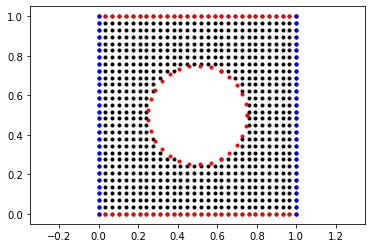

In [341]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from global_constants import L, R, X0, Y0, EPS0, MU, LBD


# Compute collocation points
N = 30
x, y = np.meshgrid(
    np.linspace(0, L, N, dtype=np.float32),
    np.linspace(0, L, N, dtype=np.float32),
)
mask = (((x - X0) ** 2 + (y - Y0) ** 2) > R**2)
X = x[mask]
Y = y[mask]

# Boundaries
Xl = x[x == 0]
Yl = y[x == 0]
Xr = x[x == L]
Yr = y[x == L]
Xb = x[y == 0]
Yb = y[y == 0]
Xt = x[y == L]
Yt = y[y == L]
phi = np.linspace(0, 2 * np.pi, N, dtype=np.float32)
Xh = R * np.cos(phi) + X0
Yh = R * np.sin(phi) + Y0


# Visualize geometry (Dirichlet blue, Neumann red)
plt.plot(X, Y, ".k")
plt.plot(Xh, Yh, ".r")
plt.plot(Xt, Yt, ".r")
plt.plot(Xb, Yb, ".r")
plt.plot(Xr, Yr, ".b")
plt.plot(Xl, Yl, ".b")
plt.axis("equal");


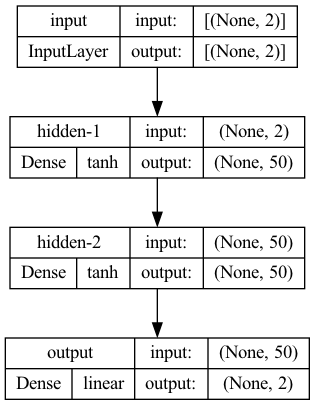

In [342]:
# build a dense multi-layer perceptron ANN to approximate the displacement field
model = keras.models.Sequential()
model.add(keras.Input(shape=(2,), name="input"))
model.add(keras.layers.Dense(50, activation="tanh", name="hidden-1"))
model.add(keras.layers.Dense(50, activation="tanh", name="hidden-2"))
model.add(keras.layers.Dense(2, activation="linear", name="output"))

keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)


In [343]:
@tf.function
def sigma(eps):
    N = eps.shape[0]
    I = tf.eye(2)
    return 2.0 * MU * eps + LBD * tf.einsum("...ii,...jk->...jk", eps, I)

@tf.function
def epsilon(x, y):
    x = tf.convert_to_tensor(x)
    y = tf.convert_to_tensor(y)

    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)
        disp = model(tf.stack([x, y], axis=1))
        u = disp[:, 0]
        v = disp[:, 1]
    ux = g.gradient(u, x)
    uy = g.gradient(u, y)
    vx = g.gradient(v, x)
    vy = g.gradient(v, y)

    gradx = tf.stack([ux, vx], axis=1)
    grady = tf.stack([uy, vy], axis=1)
    grad = tf.stack([gradx, grady], axis=2)

    return 0.5 * (grad + tf.transpose(grad, perm=[0, 2, 1]))

@tf.function
def pde_residual(x,y):
    x = tf.convert_to_tensor(x)
    y = tf.convert_to_tensor(y)

    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)
        stress = sigma(epsilon(x,y))
        s_xx = stress[:,0,0]
        s_xy = stress[:,0,1]
        s_yy = stress[:,1,1]

    residual_x = g.gradient(s_xx, x) + g.gradient(s_xy, y)
    residual_y = g.gradient(s_xy, x) + g.gradient(s_yy, y)
    return residual_x, residual_y


In [344]:
@tf.function
def loss(pos, _):
    x = pos[:, 0]
    y = pos[:, 1]

    # # strain energy
    # strain = epsilon(x, y)
    # stress = sigma(strain)
    # strain_energy = 0.5 * tf.einsum("...ij,...ij->...", stress, strain)
    # total_strain_energy = tf.reduce_sum(strain_energy)

    # pde
    res_x, res_y = pde_residual(x,y)
    pde_error = tf.reduce_sum(tf.square(res_x)) + tf.reduce_sum(tf.square(res_y))

    # left boundary
    displ = model(tf.stack([Xl, Yl], axis=1))
    left_error = tf.reduce_sum(tf.square(displ[:, 0])) + tf.reduce_sum(
        tf.square(displ[:, 1])
    )

    # right boundary
    dispr = model(tf.stack([Xr, Yr], axis=1))
    right_error = tf.reduce_sum(tf.square(dispr[:, 0] - EPS0 * L)) + tf.reduce_sum(
        tf.square(dispr[:, 1])
    )
    
    # top boundary
    stresst = sigma(epsilon(Xt, Yt))
    top_error = tf.reduce_sum(tf.square(stresst[:, 1, 1])) + tf.reduce_sum(
        tf.square(stresst[:, 0, 1])
    )
    # bottom boundary
    stressb = sigma(epsilon(Xb, Yb))
    bottom_error = tf.reduce_sum(tf.square(stressb[:, 1, 1])) + tf.reduce_sum(
        tf.square(stressb[:, 0, 1])
    )
    # hole boundary
    stressh = sigma(epsilon(Xh, Yh))
    nx = -tf.convert_to_tensor((Xh - X0)/R)
    ny = -tf.convert_to_tensor((Yh - Y0)/R)
    normal = tf.stack([nx, ny], axis=1)
    traction = tf.einsum("...ij,...j->...i", stressh, normal)
    hole_error = tf.reduce_sum(tf.square(traction[:, 0])) + tf.reduce_sum(
        tf.square(traction[:, 1])
    )

    return (
        left_error
        + right_error
        # + top_error
        # + bottom_error
        # + hole_error
        + pde_error
    )


In [345]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=loss)

positions = tf.stack([X, Y], axis=1)
dummy = tf.zeros_like(positions)
history = model.fit(positions, dummy, epochs=800)


Epoch 1/800
23/23 [==============================] - 3s 838us/step - loss: 2.1132
Epoch 2/800
23/23 [==============================] - 0s 773us/step - loss: 0.1431
Epoch 3/800
23/23 [==============================] - 0s 793us/step - loss: 0.0131
Epoch 4/800
23/23 [==============================] - 0s 828us/step - loss: 0.0013
Epoch 5/800
23/23 [==============================] - 0s 905us/step - loss: 1.9637e-04
Epoch 6/800
23/23 [==============================] - 0s 918us/step - loss: 9.5668e-05
Epoch 7/800
23/23 [==============================] - 0s 914us/step - loss: 7.8878e-05
Epoch 8/800
23/23 [==============================] - 0s 897us/step - loss: 7.1135e-05
Epoch 9/800
23/23 [==============================] - 0s 926us/step - loss: 6.4469e-05
Epoch 10/800
23/23 [==============================] - 0s 925us/step - loss: 5.8316e-05
Epoch 11/800
23/23 [==============================] - 0s 946us/step - loss: 5.2664e-05
Epoch 12/800
23/23 [==============================] - 0s 1ms/step - 

23/23 [==============================] - 0s 341us/step


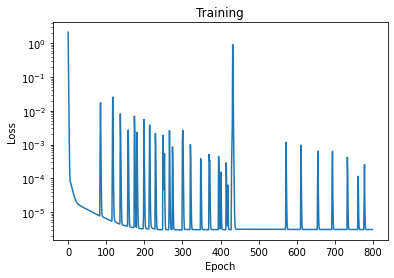

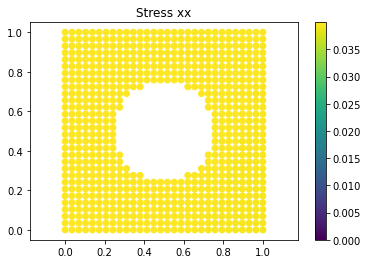

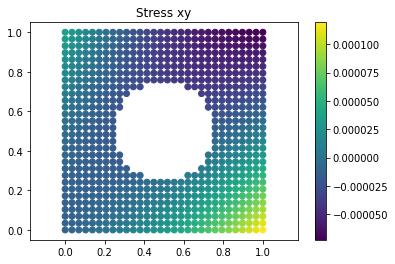

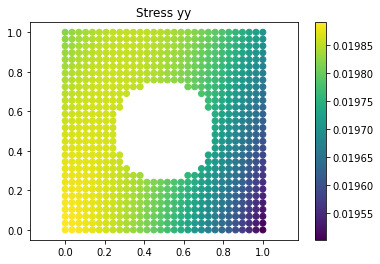

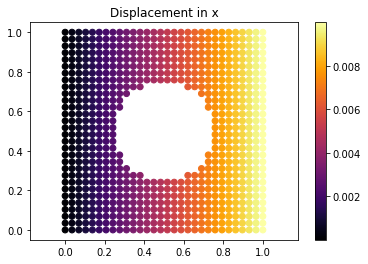

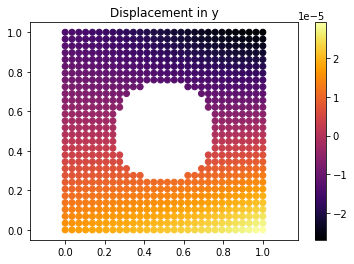

In [346]:
disp = model.predict(positions)
strain = epsilon(positions[:, 0], positions[:, 1])
stress = sigma(strain)


plt.semilogy(history.history["loss"])
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()


plt.scatter(positions[:, 0], positions[:, 1], c=stress[:, 0, 0], vmin=0)
plt.axis("equal")
plt.colorbar()
plt.title("Stress xx")
plt.show()

plt.scatter(positions[:, 0], positions[:, 1], c=stress[:, 0, 1])
plt.axis("equal")
plt.colorbar()
plt.title("Stress xy")
plt.show()

plt.scatter(positions[:, 0], positions[:, 1], c=stress[:, 1, 1])
plt.axis("equal")
plt.colorbar()
plt.title("Stress yy")
plt.show()

plt.scatter(positions[:, 0], positions[:, 1], c=disp[:, 0], cmap="inferno")
plt.axis("equal")
plt.colorbar()
plt.title("Displacement in x")
plt.show()

plt.scatter(positions[:, 0], positions[:, 1], c=disp[:, 1], cmap="inferno")
plt.axis("equal")
plt.colorbar()
plt.title("Displacement in y")
plt.show()
